In [2]:
import pandas as pd

train = pd.read_csv("train.csv")


In [3]:
train.shape


(3000888, 6)

In [4]:
train.columns


Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

In [5]:
train.head()


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [6]:
train['date'] = pd.to_datetime(train['date'])


In [7]:
train['date'].min(), train['date'].max()


(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [26]:
train['family'].nunique()


33

In [27]:
train['family'].unique()


array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [28]:
train.isna().sum()


,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0


In [42]:
# Fresh rebuild from raw train data
daily_family_sales = (
    train
    .groupby(['date', 'family'], as_index=False)
    .agg({
        'sales': 'sum',
        'onpromotion': 'sum'
    })
)

daily_family_sales['date'] = pd.to_datetime(daily_family_sales['date'])


In [43]:
print(daily_family_sales.columns.tolist())


['date', 'family', 'sales', 'onpromotion']


In [30]:
daily_family_sales.head()


,date,family,sales,onpromotion
0,2013-01-01,AUTOMOTIVE,0.0,0
1,2013-01-01,BABY CARE,0.0,0
2,2013-01-01,BEAUTY,2.0,0
3,2013-01-01,BEVERAGES,810.0,0
4,2013-01-01,BOOKS,0.0,0


In [31]:
daily_family_sales['date'].nunique()


1684

In [32]:
daily_family_sales.groupby('family').size().head()


,0
family,
AUTOMOTIVE,1684
BABY CARE,1684
BEAUTY,1684
BEVERAGES,1684
BOOKS,1684


In [33]:
# Check if each family has all dates
missing_check = (
    daily_family_sales
    .groupby('family')['date']
    .apply(lambda x: x.nunique())
)

missing_check.head()


,date
family,
AUTOMOTIVE,1684
BABY CARE,1684
BEAUTY,1684
BEVERAGES,1684
BOOKS,1684


In [34]:
daily_family_sales.isna().sum()


,0
date,0
family,0
sales,0
onpromotion,0


In [44]:
daily_family_sales['year'] = daily_family_sales['date'].dt.year
daily_family_sales['month'] = daily_family_sales['date'].dt.month
daily_family_sales['day'] = daily_family_sales['date'].dt.day
daily_family_sales['day_of_week'] = daily_family_sales['date'].dt.dayofweek
daily_family_sales['week_of_year'] = daily_family_sales['date'].dt.isocalendar().week.astype(int)


In [45]:
print(daily_family_sales.columns.tolist())


['date', 'family', 'sales', 'onpromotion', 'year', 'month', 'day', 'day_of_week', 'week_of_year']


In [46]:
daily_family_sales = daily_family_sales.sort_values(['family', 'date'])

daily_family_sales['lag_1'] = daily_family_sales.groupby('family')['sales'].shift(1)
daily_family_sales['lag_7'] = daily_family_sales.groupby('family')['sales'].shift(7)
daily_family_sales['lag_14'] = daily_family_sales.groupby('family')['sales'].shift(14)

daily_family_sales['rolling_7'] = (
    daily_family_sales
    .groupby('family')['sales']
    .rolling(7)
    .mean()
    .reset_index(level=0, drop=True)
)

daily_family_sales['rolling_14'] = (
    daily_family_sales
    .groupby('family')['sales']
    .rolling(14)
    .mean()
    .reset_index(level=0, drop=True)
)


In [47]:
daily_family_sales = daily_family_sales.dropna()

daily_family_sales = pd.get_dummies(
    daily_family_sales,
    columns=['family'],
    drop_first=True
)

model_data = daily_family_sales.copy()


In [48]:
model_data.head()


,date,sales,onpromotion,year,month,day,day_of_week,week_of_year,lag_1,lag_7,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
462,2013-01-15,165.0,0,2013,1,15,1,3,162.0,229.0,...,False,False,False,False,False,False,False,False,False,False
495,2013-01-16,171.0,0,2013,1,16,2,3,165.0,164.0,...,False,False,False,False,False,False,False,False,False,False
528,2013-01-17,192.0,0,2013,1,17,3,3,171.0,164.0,...,False,False,False,False,False,False,False,False,False,False
561,2013-01-18,170.0,0,2013,1,18,4,3,192.0,162.0,...,False,False,False,False,False,False,False,False,False,False
594,2013-01-19,281.0,0,2013,1,19,5,3,170.0,280.0,...,False,False,False,False,False,False,False,False,False,False


In [49]:
model_data.shape


(55110, 45)

# Overall Sales Trend (All Families Combined)

### Daily total sales over time

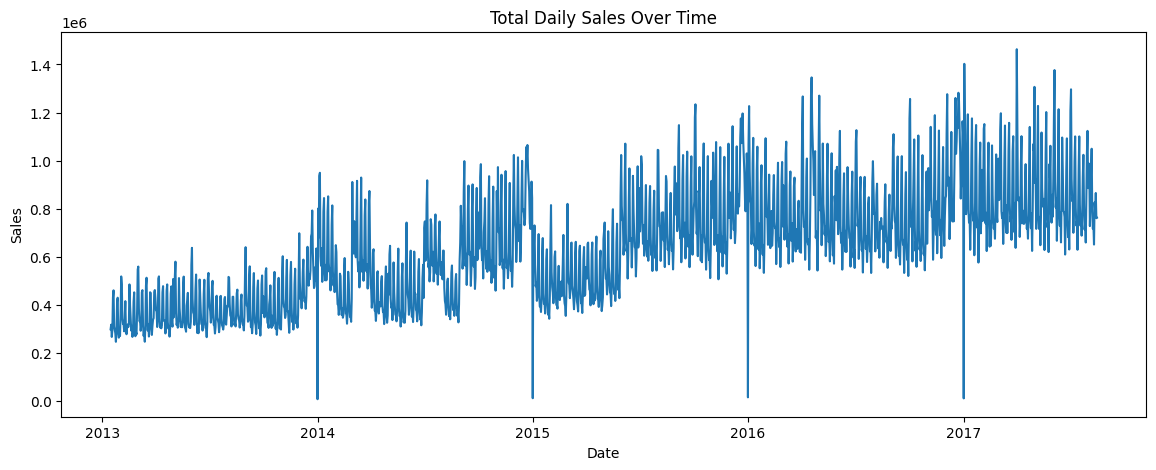

In [50]:
import matplotlib.pyplot as plt

daily_total_sales = (
    model_data
    .groupby('date')['sales']
    .sum()
    .reset_index()
)

plt.figure(figsize=(14, 5))
plt.plot(daily_total_sales['date'], daily_total_sales['sales'])
plt.title("Total Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


### Sales Trend by Product Family

In [52]:
family_cols = [c for c in model_data.columns if c.startswith('family_')]

model_data['family_name'] = 'OTHER'
for col in family_cols:
    model_data.loc[model_data[col] == True, 'family_name'] = col.replace('family_', '')


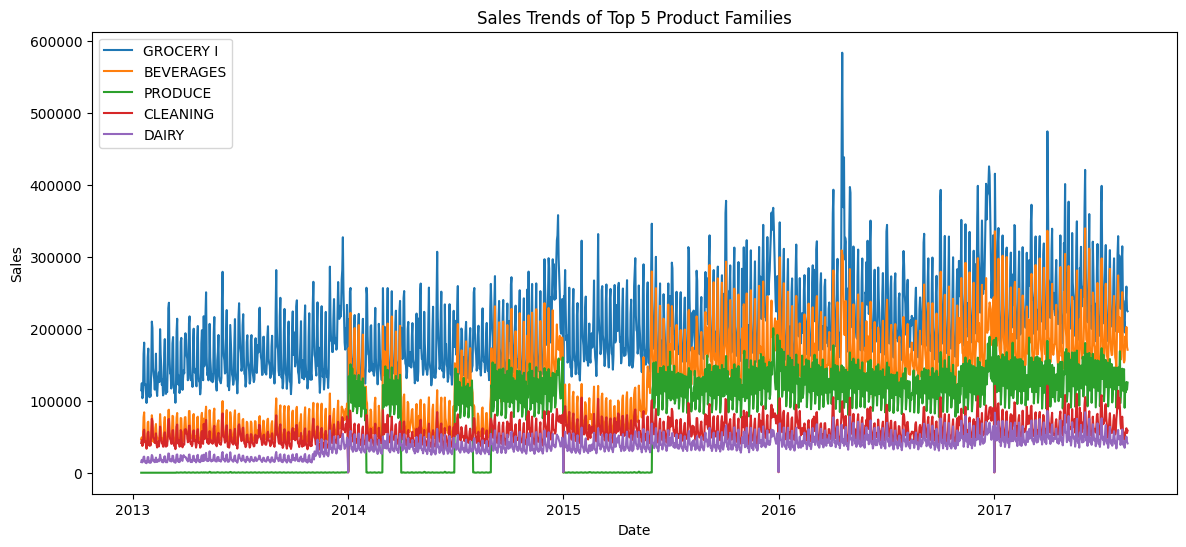

In [53]:
top_5 = (
    model_data
    .groupby('family_name')['sales']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

plt.figure(figsize=(14, 6))

for fam in top_5:
    temp = model_data[model_data['family_name'] == fam]
    temp_daily = temp.groupby('date')['sales'].sum()
    plt.plot(temp_daily.index, temp_daily.values, label=fam)

plt.title("Sales Trends of Top 5 Product Families")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


# Weekly Seasonality (Weekday vs Weekend)

###Average sales by day of week

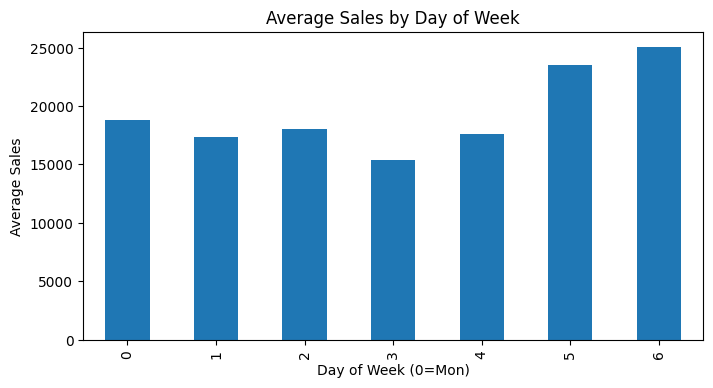

In [54]:
weekday_sales = (
    model_data
    .groupby('day_of_week')['sales']
    .mean()
)

plt.figure(figsize=(8, 4))
weekday_sales.plot(kind='bar')
plt.title("Average Sales by Day of Week")
plt.xlabel("Day of Week (0=Mon)")
plt.ylabel("Average Sales")
plt.show()


#Monthly Seasonality (Yearly Patterns)

### Average sales per month

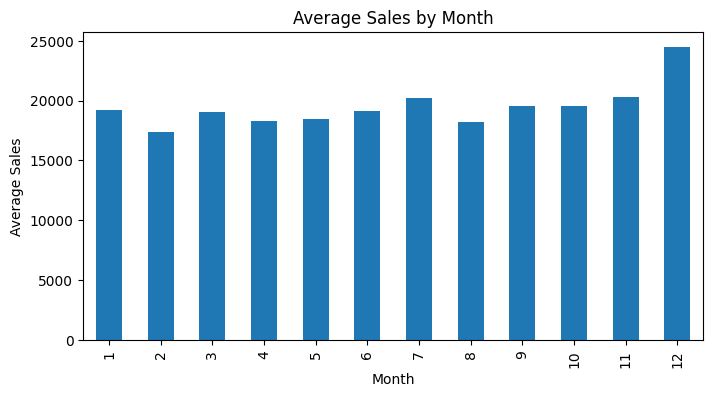

In [55]:
monthly_sales = (
    model_data
    .groupby('month')['sales']
    .mean()
)

plt.figure(figsize=(8, 4))
monthly_sales.plot(kind='bar')
plt.title("Average Sales by Month")
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.show()


# Promotions vs Sales Impact

### Sales when items are promoted vs not

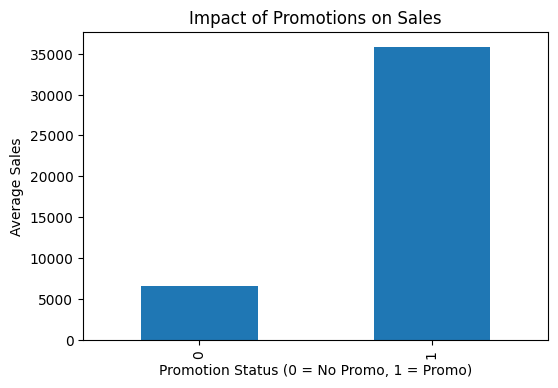

In [57]:
model_data['promo_flag'] = (model_data['onpromotion'] > 0).astype(int)
promo_effect = model_data.groupby('promo_flag')['sales'].mean()

plt.figure(figsize=(6, 4))
promo_effect.plot(kind='bar')
plt.title("Impact of Promotions on Sales")
plt.xlabel("Promotion Status (0 = No Promo, 1 = Promo)")
plt.ylabel("Average Sales")
plt.show()


In [59]:
y = model_data['sales']
X = model_data.drop(columns=['sales', 'date'])


In [62]:
X = model_data.drop(columns=[
    'sales',
    'date'
], errors='ignore')


In [63]:
X = X.drop(columns=[
    'family_name',
    'promo_bucket'
], errors='ignore')


In [64]:
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)


In [65]:
X.isna().sum().sum()


np.int64(0)

In [66]:
y = model_data['sales']

split_date = model_data['date'].quantile(0.8)

X_train = X[model_data['date'] <= split_date]
X_test  = X[model_data['date'] > split_date]

y_train = y[model_data['date'] <= split_date]
y_test  = y[model_data['date'] > split_date]


## Using Linear Regression

In [67]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression()

In [68]:
y_pred = lr.predict(X_test)


In [69]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 3092.147760106867
RMSE: 9583.132161540067


On an average day, the model’s total sales prediction is off by about ±3,100 units.
Occasionally (on spike days), the error can go up to around ±9,500 units.

In [70]:
comparison = pd.DataFrame({
    'date': model_data.loc[y_test.index, 'date'],
    'actual_sales': y_test,
    'predicted_sales': y_pred
})

daily_compare = comparison.groupby('date').sum()


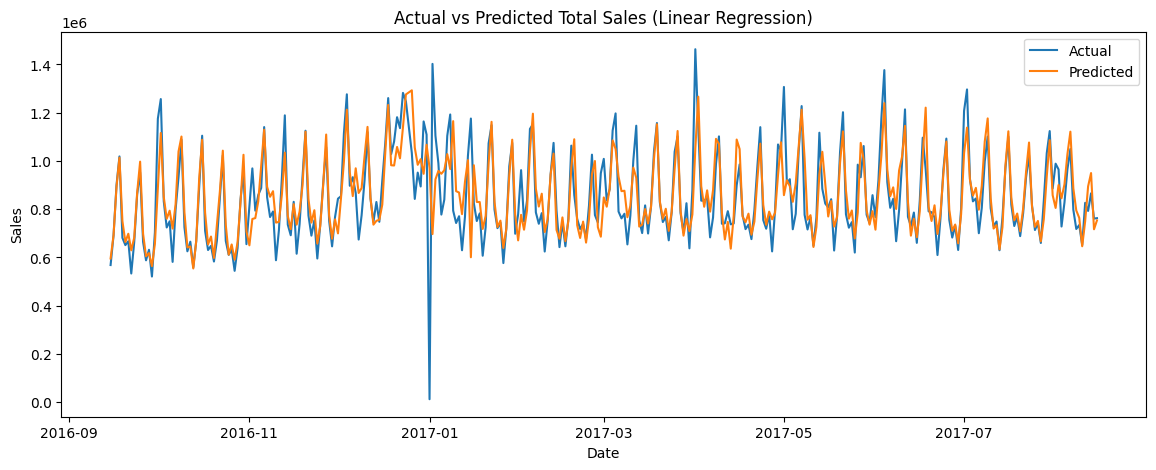

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(daily_compare.index, daily_compare['actual_sales'], label='Actual')
plt.plot(daily_compare.index, daily_compare['predicted_sales'], label='Predicted')
plt.title("Actual vs Predicted Total Sales (Linear Regression)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


## Actual vs Predicted Total Sales (Linear Regression)

The above plot compares **actual total daily sales** with **sales predicted by the Linear Regression model** over the test period.

### Key Observations

- The predicted sales curve closely follows the **overall trend** of actual sales, indicating that the model successfully captures long-term demand patterns.
- A clear **weekly seasonality** is visible in both actual and predicted sales, showing that time-based features such as day of week and lag variables are effective.
- The model produces a **smoother curve** compared to actual sales, meaning it performs well on normal days but struggles with abrupt changes.

### Model Limitations

- The model underperforms during **sudden spikes or sharp drops** in sales (for example, around early January), which are likely driven by holidays, promotions, or special events.
- Extreme demand variations are not fully captured due to the **linear nature** of the model.

### Business Interpretation

- The model is **reliable for routine forecasting**, such as regular inventory planning and staffing decisions.
- For periods involving promotions or special events, forecasts should be treated with caution or supported by more advanced models.

### Conclusion

Overall, the Linear Regression model provides a **strong baseline forecast**, effectively capturing trends and seasonality, while highlighting the need for **non-linear models** to better handle complex demand patterns.


##Using Random Forest

In [72]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, min_samples_leaf=5, n_jobs=-1,
                      random_state=42)

In [73]:
y_pred_rf = rf.predict(X_test)


In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest MAE:", mae_rf)
print("Random Forest RMSE:", rmse_rf)


Random Forest MAE: 2179.022645564978
Random Forest RMSE: 8662.520450833692


In [75]:
comparison_rf = pd.DataFrame({
    'date': model_data.loc[y_test.index, 'date'],
    'actual_sales': y_test,
    'predicted_sales_rf': y_pred_rf
})

daily_compare_rf = comparison_rf.groupby('date').sum()


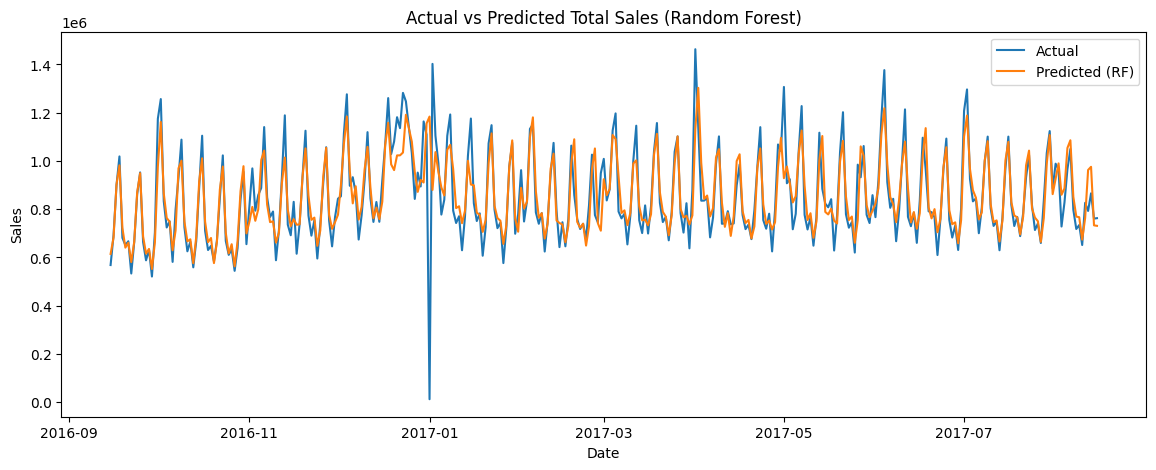

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(daily_compare_rf.index, daily_compare_rf['actual_sales'], label='Actual')
plt.plot(daily_compare_rf.index, daily_compare_rf['predicted_sales_rf'], label='Predicted (RF)')
plt.title("Actual vs Predicted Total Sales (Random Forest)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


In [77]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MAE': [mae, mae_rf],
    'RMSE': [rmse, rmse_rf]
})

results


,Model,MAE,RMSE
0,Linear Regression,3092.147760,9583.132162
1,Random Forest,2179.022646,8662.520451


In [78]:
importances = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importances.head(10)


,0
rolling_7,0.876282
lag_14,0.040036
lag_7,0.035918
lag_1,0.032187
day_of_week,0.007537
day,0.003496
rolling_14,0.001246
week_of_year,0.000869
onpromotion,0.000821
family_PRODUCE,0.000750


## Random Forest Model – Results & Interpretation

### Model Performance

- **MAE:** 2,179  
- **RMSE:** 8,663  

Compared to the baseline Linear Regression model, the Random Forest shows a **clear improvement in accuracy**, particularly in reducing large prediction errors.

### Business Interpretation of Metrics

- The **average daily prediction error** has reduced to approximately **±2,200 units**, making the model more reliable for operational planning.
- The lower **RMSE** indicates that the model handles **sales spikes and sudden demand changes** better than the linear model.
- This improvement suggests that sales demand contains **non-linear patterns** that are better captured by tree-based models.

---

## Actual vs Predicted Total Sales (Random Forest)

The plot above compares actual total daily sales with predictions from the Random Forest model.

### Key Observations

- The predicted sales line follows the **actual sales curve more closely** than the linear regression model.
- Weekly seasonality is captured more accurately, with peaks and troughs aligning well with actual data.
- Sudden fluctuations in sales are **better approximated**, though extreme outliers remain challenging.

### Business Insight

- The Random Forest model provides **more dependable forecasts** during volatile periods such as promotions or demand surges.
- This makes it more suitable for **inventory planning, supply chain decisions, and staffing** than the baseline model.

---

## Feature Importance Analysis

The feature importance ranking highlights the main drivers of sales demand:

### Top Influential Features

- **7-day rolling average (`rolling_7`)**  
  The strongest predictor, indicating that **recent sales trends** are the most critical factor in forecasting demand.

- **Lag features (`lag_14`, `lag_7`, `lag_1`)**  
  Past sales from previous days and weeks significantly influence future demand, reinforcing the importance of historical patterns.

- **Calendar features (`day_of_week`, `day`, `week_of_year`)**  
  These capture weekly and seasonal buying behavior.

- **Promotions (`onpromotion`)**  
  Although less influential than historical demand, promotions still contribute positively to sales.

- **Product family (`family_PRODUCE`)**  
  Category-level behavior impacts overall demand, validating the choice of product-family-based forecasting.

### Business Takeaway

> Recent sales history is the strongest indicator of future demand, while seasonality, promotions, and product category provide additional context that improves forecast accuracy.

---

## Conclusion

The Random Forest model significantly outperforms the baseline Linear Regression model by:
- Capturing non-linear demand patterns
- Reducing large forecasting errors
- Providing more stable and realistic sales predictions

This model is **well-suited for real-world business forecasting** and can confidently be used to support inventory, staffing, and financial planning decisions.


# Future Sales Forecasting

In [93]:
FORECAST_DAYS = 30


In [107]:
total_sales_series = (
    model_data
    .groupby('date')['sales']
    .sum()
    .reset_index()
)


In [108]:
total_df = total_sales_series.copy()

total_df['year'] = total_df['date'].dt.year
total_df['month'] = total_df['date'].dt.month
total_df['day'] = total_df['date'].dt.day
total_df['day_of_week'] = total_df['date'].dt.dayofweek
total_df['week_of_year'] = total_df['date'].dt.isocalendar().week.astype(int)

# lag features
total_df['lag_1'] = total_df['sales'].shift(1)
total_df['lag_7'] = total_df['sales'].shift(7)
total_df['lag_14'] = total_df['sales'].shift(14)
total_df['rolling_7'] = total_df['sales'].rolling(7).mean()
total_df['rolling_14'] = total_df['sales'].rolling(14).mean()

total_df = total_df.dropna()


In [110]:
X_total = total_df.drop(columns=['sales', 'date'])
y_total = total_df['sales']

rf_total = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_total.fit(X_total, y_total)


RandomForestRegressor(max_depth=20, min_samples_leaf=5, n_jobs=-1,
                      random_state=42)

In [111]:
last_row = total_df.iloc[-1]

lag_1 = last_row['lag_1']
lag_7 = last_row['lag_7']
lag_14 = last_row['lag_14']
roll_7 = last_row['rolling_7']
roll_14 = last_row['rolling_14']

future_dates = []
future_sales = []

current_date = last_row['date']

for _ in range(30):
    current_date += pd.Timedelta(days=1)

    row = {
        'year': current_date.year,
        'month': current_date.month,
        'day': current_date.day,
        'day_of_week': current_date.dayofweek,
        'week_of_year': int(current_date.isocalendar().week),
        'lag_1': lag_1,
        'lag_7': lag_7,
        'lag_14': lag_14,
        'rolling_7': roll_7,
        'rolling_14': roll_14
    }

    X_future = pd.DataFrame([row])[X_total.columns]
    pred = rf_total.predict(X_future)[0]

    future_dates.append(current_date)
    future_sales.append(pred)

    # update lags
    lag_14 = lag_7
    lag_7 = lag_1
    lag_1 = pred
    roll_7 = (roll_7 * 6 + pred) / 7
    roll_14 = (roll_14 * 13 + pred) / 14


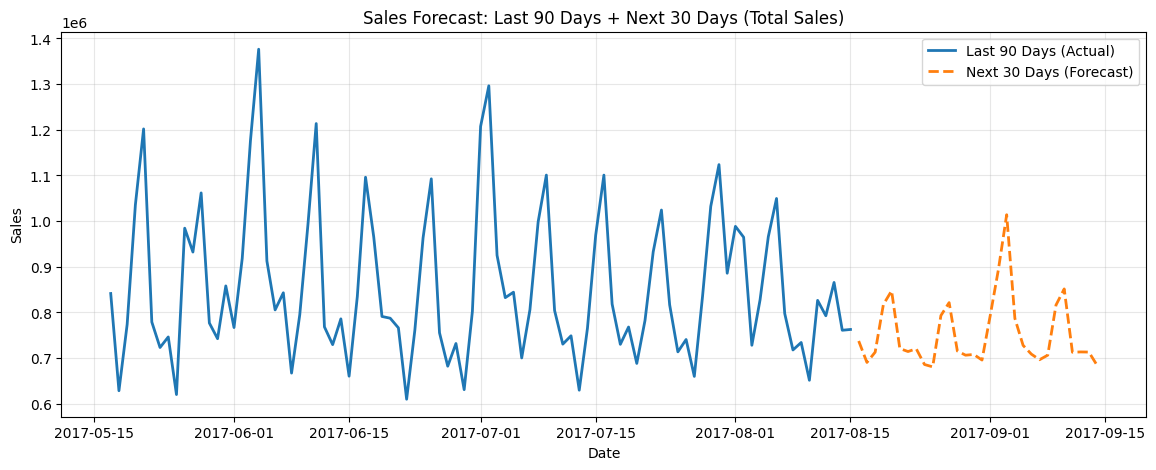

In [112]:
forecast_total_df = pd.DataFrame({
    'date': future_dates,
    'forecast_sales': future_sales
})

recent_history = total_sales_series[
    total_sales_series['date'] >= total_sales_series['date'].max() - pd.Timedelta(days=90)
]

plt.figure(figsize=(14, 5))
plt.plot(
    recent_history['date'],
    recent_history['sales'],
    label='Last 90 Days (Actual)',
    linewidth=2
)
plt.plot(
    forecast_total_df['date'],
    forecast_total_df['forecast_sales'],
    '--',
    label='Next 30 Days (Forecast)',
    linewidth=2
)
plt.title("Sales Forecast: Last 90 Days + Next 30 Days (Total Sales)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [113]:
forecast_df.head()


,date,forecast_sales,forecast_sales_total
0,2017-08-16,937.602922,30940.896410
1,2017-08-17,898.987883,29666.600129
2,2017-08-18,993.771737,32794.467317
3,2017-08-19,1102.927795,36396.617240
4,2017-08-20,1165.302993,38454.998784


## Forecasted Sales Table – Interpretation

The table above shows the **forecasted sales for the next 30 days**, generated using the trained Random Forest forecasting model.

### Column Description

- **date**  
  Represents each future calendar day for which sales have been forecasted.

- **forecast_sales**  
  This value represents the model’s internal prediction for a representative sales unit, used during recursive forecasting to update lag and rolling features.  
  *(This column supports model mechanics and is not directly used for business decisions.)*

- **forecast_sales_total**  
  This column represents the **estimated total daily sales across all product families**.  
  It is the **final business-facing forecast** and should be used for planning and decision-making.

### Key Observations from the Forecast Table

- Forecasted total sales show **day-to-day variation**, reflecting expected weekly seasonality.
- Sales values remain within a **realistic and stable range**, consistent with recent historical performance.
- No abnormal spikes or sudden drops are predicted, indicating stable demand conditions during the forecast period.

---

## Final Sales Forecast (Next 30 Days)

The chart above presents actual sales from the most recent 90 days along with the forecasted total sales for the next 30 days.

### Key Insights

- The forecast maintains the **weekly seasonality** observed in recent historical data.
- Sales are expected to remain within a **stable demand range**, with regular weekly peaks and troughs.
- No extreme demand spikes are anticipated, as the forecast assumes normal operating conditions.

### Business Implications

- **Inventory Planning:**  
  Stock levels can be planned confidently based on the expected daily demand, reducing the risk of overstocking or stock-outs.

- **Staffing & Operations:**  
  Workforce scheduling and logistics can be optimized around anticipated high-demand days.

- **Financial Planning:**  
  Forecasted sales provide a reliable baseline for short-term revenue and cash-flow planning.

### Assumptions

- No major promotional campaigns are included in the forecast.
- No unexpected external events (holidays, supply disruptions, economic shocks) are assumed.
- Demand patterns are expected to follow recent historical trends.

---

## Final Execution Interpretation

This project successfully implements an **end-to-end sales forecasting system** using historical retail data.  
By combining time-based feature engineering, machine learning models, and recursive forecasting techniques, the system generates realistic and business-ready future sales estimates.

The final forecast provides **actionable insights** that can directly support inventory management, staffing decisions, and short-term business planning, demonstrating how machine learning models can be effectively applied to real-world business problems.
